# Single compartmental model - active soma

We define and then numerically simulate a single compartment, made of a membrane equipped with both *leak* (i.e., non voltage-dependent) ion channels as well as *active* (i.e., voltage-gated) sodium and potassium conductances. A current-clamp microelectrode, stimulating intracellularly by a step-wise DC waveform of amplitude $I_{stim}(t)$ is also *inserted* inside the membrane and used to stimulate the compartment.

The membrane potential $V$ evolves in time according to a system of 4 ordinary differential equations coupled together:

$C \frac{dV(t)}{dt}\ = \ G_{leak} (E_{leak} - V) + G_{Na} m^3 h (E_{Na} - V) + G_{K} n^4 (E_{K} - V) + I_{dend} + I_{stim}$

$\frac{dn}{dt}\ = \ \alpha_n (1 - n) - \beta_n n$

$\frac{dm}{dt}\ = \ \alpha_m (1 - m) - \beta_m m$

$\frac{dh}{dt}\ = \ \alpha_h (1 - h) - \beta_h h$


The initial condition is also provided

$V(0) = -70 mV$

In [1]:
#@title NEURON install (launch only once)
# Note: Google Colab gives you access to an "instance".
# This is a virtual machine ("container" would be more correct) that runs
# Linux with already a Python installation.
!pip install neuron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 46.5 MB/s eta 0:00:00


In [51]:
#@title Create locally a *.mod file for Nav - launch only once
# Taken from ModelDB
# https://modeldb.science/184139?tab=2&file=HyunEtAl2015/Na.mod
%%writefile nav.mod
TITLE Na

COMMENT

This file is based on na16.mod of Hu et al. (nn, 2009)

******************************************************
Sodium channel, Hodgkin-Huxley style kinetics.

Kinetics were fit to data from Huguenard et al. (1988) and Hamill et al. (1991)

qi is not well constrained by the data, since there are no points between -80 and -55.  So this was fixed at 5
while the thi1, thi2, Rg, Rd were optimized using a simplex least square proc

voltage dependencies are shifted approximately from the best fit to give higher threshold

Author: Zach Mainen, Salk Institute, 1994, zach@salk.edu
******************************************************

SHL modified as follows:
 1-1) qa: 6 -> 8
 1-2) qinf: 6.2 -> 8 mV, since qa and qinf = 8 mV  (Kim Jonas nn 12).
 cf. qa and qinf = 5.8 and 7.1 in Hu Shu nn 09
 2) tha, -43 -> -38 (Kim Jonas nn 12)
 3) use cnexp as an integration mtd
SHL End

ENDCOMMENT

INDEPENDENT {t FROM 0 TO 1 WITH 1 (ms)}

NEURON {
	SUFFIX Na
	USEION na READ ena WRITE ina
	RANGE m, h, gna, gbar
	GLOBAL tha, thi1, thi2, qa, qi, qinf, thinf
	RANGE minf, hinf, mtau, htau
	GLOBAL Ra, Rb, Rd, Rg
	GLOBAL q10, temp, tadj, vmin, vmax, vshift
}

PARAMETER {
	gbar = 0.01   	(mS/cm2)
	vshift = 0	(mV)		: voltage shift (affects all)

	tha  = -38	(mV)		: v 1/2 for act curve
	qa   = 8	(mV)		: act slope
	Ra   = 0.182	(/ms)	: prop const of alpha_m (/ms)
	Rb   = 0.124	(/ms)	: prop const of beta_m (/ms)

	thi1  = -50	(mV)		: v shift of alpha_h
	thi2  = -75	(mV)		: v shift of beta_h
	qi   = 5	(mV)	    : inact tau slope
	thinf  = -73	(mV)	: v1/2 of inact curve
	qinf  = 8	(mV)		: Slope of inact curve; 6.2 -> 8
	Rg   = 0.0091	(/ms)	: prop const of beta_h(v)
	Rd   = 0.024	(/ms)	: prop const of alpha_h(v)

	temp = 30	(degC)		: original temp
	q10  = 2.3			: temperature sensitivity

	v 		(mV)
	dt		(ms)
	celsius		(degC)
	vmin = -120	(mV)
	vmax = 100	(mV)
}


UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
	(pS) = (picosiemens)
	(um) = (micron)
}

ASSIGNED {
	ina 	(mA/cm2)
	gna		(pS/um2)
	ena		(mV)
	minf 		hinf
	mtau (ms)	htau (ms)
	tadj
}


STATE { m h }

INITIAL {
	rates(v+vshift)
	m = minf
	h = hinf
	tadj = q10^((celsius - temp)/10)
}

BREAKPOINT {
    SOLVE states METHOD cnexp
    gna = tadj*gbar*m*m*m*h
	ina = gna * (v - ena)
}

DERIVATIVE states {
    rates(v+vshift)      :   at the current v and dt.
    m' = (minf-m)*tadj/mtau
    h' = (hinf-h)*tadj/htau
}



PROCEDURE rates(vm) {
    LOCAL  a, b

	a = trap0(vm,tha,Ra,qa)
	b = trap0(-vm,-tha,Rb,qa)
	mtau = 1/(a+b)
	minf = a*mtau

	:"h" inactivation

	a = trap0(vm,thi1,Rd,qi)
	b = trap0(-vm,-thi2,Rg,qi)
	htau = 1/(a+b)
	hinf = 1/(1+exp((vm-thinf)/qinf))
}


FUNCTION trap0(v,th,a,q) {
	if (fabs(v-th) > 1e-6) {
	    trap0 = a * (v - th) / (1 - exp(-(v - th)/q))
	} else {
	    trap0 = a * q
 	}
}

Writing nav.mod


In [52]:
#@title Create locally a *.mod file for Kv - launch only once
# Taken from ModelDB
# https://modeldb.science/184139?tab=2&file=HyunEtAl2015/Na.mod
%%writefile kdr.mod

TITLE K-DR channel
: from Klee Ficker and Heinemann
: modified to account for Dax et al.
: M.Migliore 1997
: LSH changed
: 1) gmn from 0.7 to 0.5 to make tau faster
: 2) vhalfn, 13 -> -3.8 (Kim Jonas, 2012)

UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
}

PARAMETER {
	v 		(mV)
	celsius 	(degC)
	gbar	= .003 	(mho/cm2)
    vhalfn	= -3.8   	(mV)
    a0n	= 0.02  (/ms)
    zetan	= -3    (1)
    gmn	= 0.5  	(1)
	nmax	= 2  	(1)
	q10	= 1	(1)
	FRT = 39 (coulombs/joule)
}

NEURON {
	SUFFIX Kdr
	USEION k WRITE ik
    RANGE  gkdr,gbar,ik
	GLOBAL ninf,taun
}

STATE { n }

ASSIGNED {
	ik 	(mA/cm2)
    ninf
    gkdr
    taun
}

BREAKPOINT {
	SOLVE states METHOD cnexp
	gkdr 	= gbar * n
	ik 	= gkdr * ( v + 90.0 )
}

INITIAL {
	rates(v)
	n=ninf
}

FUNCTION alpn(v(mV)) {
  alpn = exp( 1.e-3 * zetan * ( v - vhalfn ) * FRT )
}

FUNCTION betn(v(mV)) {
  betn = exp( 1.e-3 * zetan * gmn * ( v - vhalfn ) * FRT )
}

DERIVATIVE states {     : exact when v held constant; integrates over dt step
        rates(v)
        n' = ( ninf - n ) / taun
}

PROCEDURE rates(v (mV)) { :callable from hoc
        LOCAL a,qt
        qt	= q10 ^ ( ( celsius - 24 ) / 10 )
        a 	= alpn(v)
        ninf 	= 1 / ( 1 + a )
        taun 	= betn(v) / ( qt * a0n * ( 1 + a ) )
	if (taun<nmax) { taun=nmax }
}

Writing kdr.mod


In [59]:
#@title Create locally a *.mod file for H currents - launch only once
# Taken from ModelDB
# https://modeldb.science/184139?tab=2&file=HyunEtAl2015/Na.mod
%%writefile h.mod

TITLE I-h channel from Magee 1998 for distal dendrites

UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)

}

PARAMETER {
	v 		(mV)
        ehd  		(mV)
	celsius 	(degC)
	ghdbar=.0001 	(mho/cm2)
        vhalfl=-81   	(mV)
	kl=-8
        vhalft=-75   	(mV)
        a0t=0.011      	(/ms)
        zetat=2.2    	(1)
        gmt=.4   	(1)
	q10=4.5
	qtl=1
}


NEURON {
	SUFFIX hd
	NONSPECIFIC_CURRENT i
        RANGE ghdbar, vhalfl
        GLOBAL linf,taul
}

STATE {
        l
}

ASSIGNED {
	i (mA/cm2)
        linf
        taul
        ghd
}

INITIAL {
	rate(v)
	l=linf
}


BREAKPOINT {
	SOLVE states METHOD cnexp
	ghd = ghdbar*l
	i = ghd*(v-ehd)

}


FUNCTION alpt(v(mV)) {
  alpt = exp(0.0378*zetat*(v-vhalft))
}

FUNCTION bett(v(mV)) {
  bett = exp(0.0378*zetat*gmt*(v-vhalft))
}

DERIVATIVE states {     : exact when v held constant; integrates over dt step
        rate(v)
        l' =  (linf - l)/taul
}

PROCEDURE rate(v (mV)) { :callable from hoc
        LOCAL a,qt
        qt=q10^((celsius-33)/10)
        a = alpt(v)
        linf = 1/(1 + exp(-(v-vhalfl)/kl))
:       linf = 1/(1+ alpl(v))
        taul = bett(v)/(qtl*qt*a0t*(1+a))
}


Overwriting h.mod


In [58]:
#@title Compile the .mod file - launch only once and then restart the restart the Colab runtime. Go to Runtime -> Restart runtime
# Compile the .mod file. This creates a directory named x86_64.
!nrnivmodl

/content
cfiles =
Mod files: "h.mod" "kdr.mod" "nav.mod"

MODOBJS= ./h.o ./kdr.o ./nav.o
 -> Compiling mod_func.cpp
 -> NMODL ../h.mod
Translating h.mod into /content/x86_64/h.cpp
Notice: Assignment to the GLOBAL variable, "linf", is not thread safe
Notice: Assignment to the GLOBAL variable, "taul", is not thread safe
 -> Compiling /content/x86_64/h.cpp
 => LINKING shared library "/content/x86_64/./libnrnmech.so"
Successfully created x86_64/special


In [1]:
#@title NEURON and other Python Libraries import
from neuron import n
import matplotlib.pyplot as plt

# run standard library for high-level simulation control functions
n.load_file("stdrun.hoc")

# Only in a jupyter notebook / jupyter lab environment
%matplotlib inline

In [18]:
#@title Define and create the model
# create model
soma  = n.Section(name="soma")
soma.L  = 10            # length µm
soma.diam = 10          # diameter µm
soma.insert('pas')      # add passive properties
soma.g_pas = 1/10000    # set the specific membrane
                        # resistance to 10000 ohm*cm^2
soma.insert('Kdr') # add potassium channel | a mod file
soma.gbar_Kdr = 0.1 # set the potassium conductance

soma.insert('Na') # add sodium channel | a mod file
soma.gbar_Na = 0.5 # set the sodium conductance

#soma.insert('hd')
#soma.ghdbar_hd = 0.00001 # set the Ih conductance


n.celsius = 30

# current clamp
stim = n.IClamp(soma(0.5))
stim.delay = 20         # start of the current injection (ms)
stim.dur  = 100         # duration (ms)
stim.amp  = 0.01        # amplitude (nA)

# record voltage at the soma, the injected current, and the time
soma_v = n.Vector()
soma_v.record(soma(0.5)._ref_v)

stim_current = n.Vector()
stim_current.record(stim._ref_i)

t = n.Vector()
t.record(n._ref_t)

Vector[14]

(-90.0, 50.0)

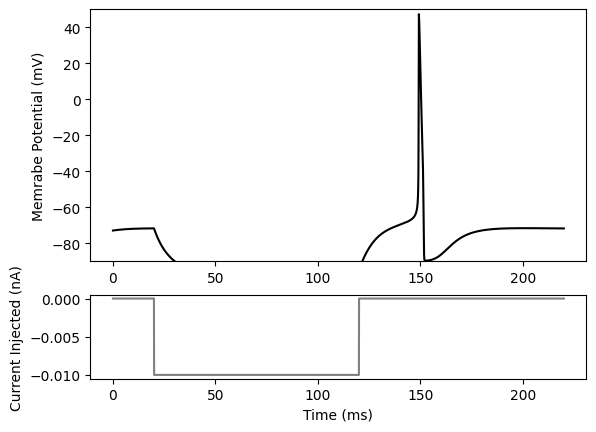

In [22]:
#@title Run the numerical simulation { run: "auto" }

n.t = 0
n.tstop = 220 # set the simulation time
n.dt = 0.025
n.v_init = -73
stim.amp = -0.01 #@param {type:"slider", min:-0.01, max:0.1, step:0.001}

n.run()



# plotting
f, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax0.plot(t,soma_v, 'k')
ax1.plot(t,stim_current, 'gray', label='I (nA)')

ax0.set_ylabel('Memrabe Potential (mV)')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current Injected (nA)')
ax0.set_ylim([-90, 50])

See what happens adding a Ih current